In [4]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install wordcloud
!pip install sklearn


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip
  Using cached matplotlib-3.5.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached Pillow-9.2.0-cp38-cp38-manylinux_2_28_x86_64.whl (3.2 MB)
  Using cached fonttools-4.34.4-py3-none-any.whl (944 kB)

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 11.5 MB/s eta 0:00:00
  Using cached scipy-1.8.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.6 MB)

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.9 MB/s eta 0:00:0031m31.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━

In [36]:
# Step 0. Load libraries and custom modules
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.style.use('tableau-colorblind10')
# Mathematical functions -----------------------------------------------
from scipy.stats import norm
# Text processors ------------------------------------------------------
import unicodedata
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# Preprocessing --------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Text modeling --------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Model creating -------------------------------------------------------
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
# Metrics --------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
# Custom functions ----------------------------------------------------- # la función que creamos nosotros
from text_preprocessing import clean_stopwords

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013), 
# ``Crowdsourcing a Word-Emotion Association Lexicon.'' 
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html  
nrc = pd.read_csv('../data/raw/NRC.csv', names=['word','sentiment','polarity'])
nrc = nrc.query('polarity == 1')

In [9]:
nrc

,word,sentiment,polarity
19,abacus,trust,1
23,abandon,fear,1
25,abandon,negative,1
27,abandon,sadness,1
30,abandoned,anger,1
...,...,...,...
141461,zest,anticipation,1
141464,zest,joy,1
141466,zest,positive,1
141469,zest,trust,1


In [11]:
# Step 1. Load the data
# Data extracted from https://www.thetrumparchive.com
# Data case: During the 2016 US presidential election, the candidate 
# Donald Trump used twitter to communicate with potential voters. 
# The campaign was during 2015-06-17 and 2016-11-08
# We'll try to analyze these campaign tweets from iPhone and Android
# Data description
# source -> device of origin
# id_str -> unique identifier
# text -> tweet text content
# created_at -> Date of creation, not including timezone
# retweet_count -> Count of retweets (difusion)
# in_reply_to_usr_id_str -> If it's a reply, grab the user id
# favourite_count -> Count of users that liked the tweet
# is_retweet -> If the post is a retweet  
# 1.1 Open data and get a glimpse
df_raw = pd.read_csv('../data/raw/trump_tweets.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   20761 non-null  object 
 1   id_str                   20761 non-null  int64  
 2   text                     20761 non-null  object 
 3   created_at               20761 non-null  object 
 4   retweet_count            20761 non-null  int64  
 5   in_reply_to_user_id_str  2442 non-null   float64
 6   favorite_count           20761 non-null  int64  
 7   is_retweet               20761 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [12]:
# 1.1 Sample some observations
df_raw.sample(10)

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
5878,Twitter Web Client,360844324801495040,Druggie @AROD is now scheming to sue the @Yank...,2013-07-26T19:29:25Z,295,NaN,161,False
17494,Twitter for Android,713031504415338497,Europe and the U.S. must immediately stop taki...,2016-03-24T15:55:32Z,9907,NaN,25263,False
6975,Twitter for Android,329582122463535104,Snow and freezing weather all over mid-section...,2013-05-01T13:04:35Z,251,NaN,116,False
8766,Twitter Web Client,301424121068273664,Always pretend that you’re working for yoursel...,2013-02-12T20:14:45Z,741,NaN,425,False
11333,Twitter Web Client,469845451865600001,"Via @itp_ab by @ctrenwith: ""'Trump effect' wil...",2014-05-23T14:20:59Z,21,NaN,21,False
8660,Twitter Web Client,302080621533081600,@EvaMannarino Hi Evelina.,2013-02-14T15:43:27Z,3,1.156168e+09,6,False
10431,Twitter for Android,518601830126075905,"President Obama, I have an idea! Pretend that ...",2014-10-05T03:21:26Z,844,NaN,924,False
12112,Twitter for Android,681157406605324288,Straighten out The Republican Party of Virgini...,2015-12-27T16:59:15Z,2233,NaN,5562,False
4590,Twitter for Android,400265224038916096,"@eminofficial Emin, your performance at Miss ...",2013-11-12T14:14:00Z,473,1.956680e+08,12,False
9132,Twitter Web Client,296365762040446976,@LynnFiorenzano Thanks Lynn!,2013-01-29T21:14:38Z,0,5.536950e+08,0,False


In [13]:
# Step 2. Transform and wrangle the data
# 2.1 Make a copy
df_interim = df_raw.copy()

In [14]:
# 2.2 Get rid of uninformative columns
df_interim = df_interim.drop(['id_str','is_retweet','in_reply_to_user_id_str'], axis=1)

In [15]:
# 2.3 Convert columns to the right format
df_interim['created_at'] = df_interim['created_at'].astype('datetime64')
df_interim['source'] = pd.Categorical(df_interim['source'])

In [16]:
# 2.4 Filter dates for analysis
df_interim = df_interim.loc[(df_interim['created_at'] >= '2015-06-17') \
    & (df_interim['created_at'] <= '2016-11-08')]

In [17]:
# 2.5 Consider time is UTC, convert to EST

df_interim['created_at'] += pd.Timedelta(-5, unit='h') # le resto 5 horas

#time delta es diferencia de tiempos

In [18]:
# 2.5 Filter source for analysis: solo iphone or android --> son los que sospechamos que son los suyos
# los de la tablet o compu pueden ser de los asesores
df_interim = df_interim.loc[(df_interim['source'].str.contains('iPhone')) \
    | (df_interim['source'].str.contains('Android'))]
df_interim['source'] = df_interim['source'].cat.remove_unused_categories()

In [20]:
# 2.5 Save and create a copy for analysis
df_interim.to_csv('../data/interim/trump_tweets.csv', index=False)
df = df_interim.copy()

In [21]:
# Step 3. Perform EDA
# 3.1 Get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 12072 to 18506
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source          3946 non-null   category      
 1   text            3946 non-null   object        
 2   created_at      3946 non-null   datetime64[ns]
 3   retweet_count   3946 non-null   int64         
 4   favorite_count  3946 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2), object(1)
memory usage: 158.0+ KB


In [22]:
# 3.2 Get a sample
df.sample(10)

,source,text,created_at,retweet_count,favorite_count
15793,Twitter for iPhone,I agree Mike - thank you to all of our law enf...,2016-10-04 20:50:48,11000,36902
16880,Twitter for Android,Bernie Sanders must really dislike Crooked Hil...,2016-06-08 20:46:03,7333,24413
16052,Twitter for Android,Crooked Hillary's V.P. pick said this morning ...,2016-09-04 11:04:21,6808,21645
13339,Twitter for Android,"As I have long stated, we are so tied in with ...",2015-08-24 08:30:48,4006,6027
16002,Twitter for Android,"I havn't seen @tonyschwartz in many years, he ...",2016-09-10 00:57:59,4265,16876
17721,Twitter for iPhone,Thank you Kentucky! #Trump2016\n#SuperSaturday,2016-03-05 22:48:02,5331,16967
17562,Twitter for iPhone,Mitt Romney is a mixed up man who doesn't have...,2016-03-18 15:37:31,4197,14217
12165,Twitter for iPhone,"Once again, #MSM is dishonest. ""Schlonged"" is ...",2015-12-22 19:47:59,4159,7452
15446,Twitter for iPhone,"Record crowd in Tampa, Florida- thank you! We ...",2016-10-24 20:43:26,15309,34493
12635,Twitter for Android,".@seanhannity Carly, whose campaign is dead, ...",2015-11-13 16:04:01,1103,3074


In [23]:
# 3.3 Describe numerical and datetime data
df.describe(datetime_is_numeric=True)

,created_at,retweet_count,favorite_count
count,3946,3946.000000,3946.000000
mean,2016-03-31 07:49:53.323872256,5839.465281,15666.982767
min,2015-06-19 20:03:05,61.000000,167.000000
25%,2015-12-20 18:19:10.500000,2013.250000,5350.000000
50%,2016-03-16 05:29:30.500000,4162.500000,11981.500000
75%,2016-07-25 09:04:26.500000,7807.250000,21527.000000
max,2016-11-07 17:21:53,168765.000000,297281.000000
std,NaN,6156.818896,14650.408743


In [24]:
# 3.4 Describe categorical data
df['source'].value_counts()

Twitter for iPhone     2099
Twitter for Android    1847
Name: source, dtype: int64

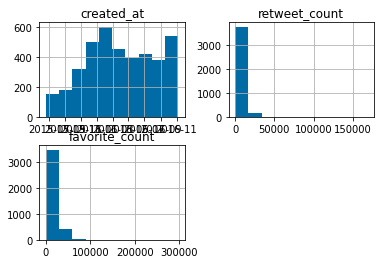

In [26]:
# 3.5 Get histograms for numerical data

df.hist()
plt.show()

- Menor actividad en 2015 luego estable y un pico al final

In [27]:
# 3.6 Make a plot of tweets frequence rate by source
# mini pipeline de pandas

df_plot = (df
            .assign(hour=df['created_at'].dt.hour) # assign para crear una columna nueva que se llama hour
            .groupby(['source', 'hour'])
            .agg(count = ('source', 'count')) # contamos la cantidad de ocurrencias por origen 
            .assign(rate = lambda df: df['count'] / df.groupby('source')['count'].sum())
            .reset_index()) 

df_plot 

# vemos por hora y por origen cuantos tweets ocurrieron

,source,hour,count,rate
0,Twitter for Android,0,22,0.011911
1,Twitter for Android,1,2,0.001083
2,Twitter for Android,2,6,0.003249
3,Twitter for Android,3,1,0.000541
4,Twitter for Android,4,28,0.015160
5,Twitter for Android,5,98,0.053059
6,Twitter for Android,6,159,0.086086
7,Twitter for Android,7,194,0.105035
8,Twitter for Android,8,210,0.113698
9,Twitter for Android,9,132,0.071467


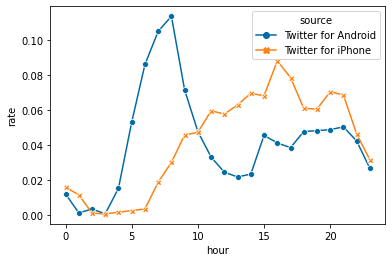

In [28]:
sns.lineplot(data=df_plot, x='hour', y='rate', hue='source', markers=True, style='source', dashes=False)
plt.show()

# se ve que hay dos personas distintas atrás del celular
# azul arranca temprano
# iphone empieza más tarde
# posiblemente hay dos personas por detrás de los tweets

In [32]:
# 3.7 Get a glimpse of the most retweeted tweets

df.sort_values(by='retweet_count', ascending=False)[['text', 'retweet_count']][:10]

,text,retweet_count
16875,How long did it take your staff of 823 people ...,168765
17183,Happy #CincoDeMayo! The best taco bowls are ma...,85465
15333,MAKE AMERICA GREAT AGAIN!,59098
15758,Here is my statement. https://t.co/WAZiGoQqMQ,51891
16548,Such a great honor to be the Republican Nomine...,41616
15340,If Obama worked as hard on straightening out o...,41479
15827,For those few people knocking me for tweeting ...,40850
15756,The media and establishment want me out of the...,40772
16583,I am pleased to announce that I have chosen Go...,38782
16848,Is President Obama going to finally mention th...,38456


In [33]:
# 3.8 Get a glimpse of the most liked tweets

df.sort_values(by='favorite_count', ascending=False)[['text', 'retweet_count']][:10]

,text,retweet_count
16875,How long did it take your staff of 823 people ...,168765
16548,Such a great honor to be the Republican Nomine...,41616
15758,Here is my statement. https://t.co/WAZiGoQqMQ,51891
15781,Mike Pence won big. We should all be proud of ...,35765
17183,Happy #CincoDeMayo! The best taco bowls are ma...,85465
15333,MAKE AMERICA GREAT AGAIN!,59098
15827,For those few people knocking me for tweeting ...,40850
15756,The media and establishment want me out of the...,40772
15340,If Obama worked as hard on straightening out o...,41479
16583,I am pleased to announce that I have chosen Go...,38782


In [34]:
# 3.9 Let's get a glimpse of common words in the tweets' text

df['text'].str.split(expand=True).stack().value_counts()[:10]

# todas stopwords

the    1965
to     1369
and    1186
I      1133
in     1098
a       987
of      957
is      904
on      829
for     703
dtype: int64

In [37]:
# 3.10 Process text to extract stopwords

# quitamos stopwords

df['text_clean'] = df.text.str.lower()

stop_dict = stopwords.words('english') #diccionario de stopwords

df['text_clean'] = df['text_clean'].apply(lambda x: clean_stopwords(x, stop_dict=stop_dict)) 
# si la funcion tiene solo un param la pongo directo en el apply, pero su son 2 tengo que hacer con lambda

df['text_clean'] = df['text_clean'].str.replace(r'''['!,.]''', '', regex=True) # cambiamos esos símbolos por un espacio vacío

In [38]:
# 3.11 Extract urls
url_pat = 'https://t.co/[A-Za-z\d]+|&amp;'

df['text_clean']=df['text_clean'].str.replace(url_pat, '', regex=True)


In [39]:
# 3.12 Extract special characters

df['text_clean']=df['text_clean'].str.replace(r'''[!.,():\-%$/'"']''', '', regex=True)

In [40]:
# 3.13 Extract numbers

df['text_clean']=df['text_clean'].str.replace(r'[\d]+', '', regex=True) # r'[\d]+' esto saca las colecciones de dígitos
# el + significa que si encuentras uno o más dígitos los saques

In [41]:
# 3.14 See the results

df[['text', 'text_clean']].sample(10)


,text,text_clean
16479,The Democrats are in a total meltdown but the ...,democrats total meltdown biased media say grea...
15396,#ObamacareFail https://t.co/iusXk4n9w7,#obamacarefail httpstcoiusxknw
12153,The silent majority- is silent no more! Rememb...,silent majority silent more remember importanc...
18001,"Wow, in the new CBS Poll I went way up into th...",wow new cbs poll went way forties thank you
16782,Crooked Hillary refuses to say that she will b...,crooked hillary refuses say raising taxes beyo...
12155,#MakeAmericaGreatAgain #Trump2016 https://t.co...,#makeamericagreatagain #trump httpstcoedeshuwq
16113,I am very proud to have brought the subject of...,proud brought subject illegal immigration back...
15954,A very interesting take from @KatiePavlich: ht...,interesting take @katiepavlich httpstcoxamyeychl
12535,".@heytana, great job - we are all proud of you!",@heytana great job proud you
15827,For those few people knocking me for tweeting ...,people knocking tweeting three oclock morning ...


In [47]:
# 3.15 Let's see a wordcloud

text = ' '.join(i for i in df.text_clean)

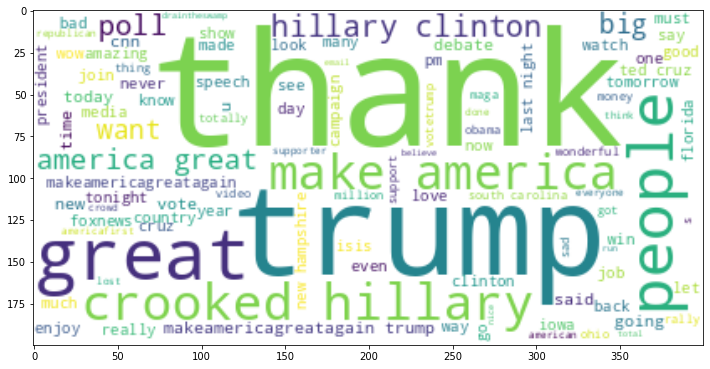

In [51]:
wordcloud = WordCloud(max_words=100,background_color='White').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

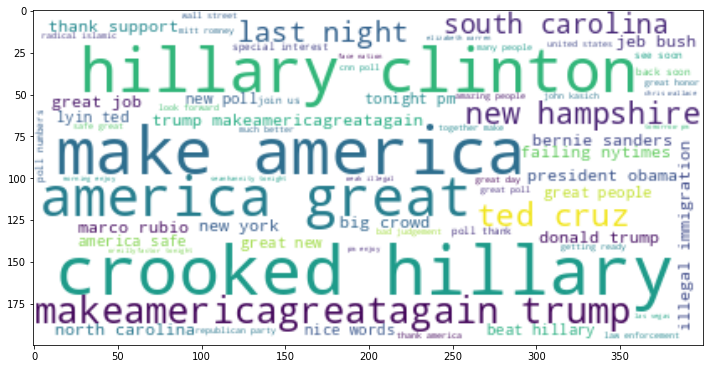

In [52]:
# bigramas
# unimos de a dos palabras y vemos cuánto se repiten

wordcloud_bi = WordCloud(collocation_threshold=2, collocations=True, max_words=100,background_color='White').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud_bi, interpolation='bilinear')
plt.show()

In [53]:
# vamos a asociar cada palabra que dice con un sentimiento

df_word_split = (df
                 .drop(['text', 'created_at', 'retweet_count','favorite_count'], axis=1)
                 .assign(text = df['text_clean'].str.split())).explode('text').drop('text_clean', axis=1).rename(columns={'text': 'word'}) 

# expand crea una fila para cada palabra

df_word_split

,source,word
12072,Twitter for Android,would
12072,Twitter for Android,like
12072,Twitter for Android,wish
12072,Twitter for Android,everyone
12072,Twitter for Android,happy
...,...,...
18506,Twitter for Android,together
18506,Twitter for Android,make
18506,Twitter for Android,america
18506,Twitter for Android,great


In [54]:
# vamos a juntarlo con el diccionario de sentimientos

df_word_split.merge(nrc[['word', 'sentiment']], on='word', how='inner')
# columna de union es word

,source,word,sentiment
0,Twitter for Android,happy,anticipation
1,Twitter for Android,happy,joy
2,Twitter for Android,happy,positive
3,Twitter for Android,happy,trust
4,Twitter for iPhone,happy,anticipation
...,...,...,...
17547,Twitter for Android,stiff,negative
17548,Twitter for Android,embarrassment,fear
17549,Twitter for Android,embarrassment,negative
17550,Twitter for Android,embarrassment,sadness


In [57]:
df_sent = df_word_split.\
merge(nrc[['word','sentiment']], on='word', how='inner').\
groupby(['source', 'sentiment']).agg(count=('sentiment', 'count')).\
reset_index().pivot_table(index=['sentiment'],columns=['source'], values='count').\
reset_index().\
rename(columns={'Twitter for Android': 'Android', 'Twitter for iPhone': 'iPhone'})

# \ permite hacer multilinea

In [58]:
df_sent

source,sentiment,Android,iPhone
0,anger,949,514
1,anticipation,986,725
2,disgust,632,307
3,fear,815,477
4,joy,743,543
5,negative,1671,925
6,positive,1963,1522
7,sadness,911,512
8,surprise,587,385
9,trust,1363,1022


In [64]:
# frecuencias relativas
# odds ratio
# vamos a calcular un IC

df_odd_ratio = df_sent.\
               assign(odd_ratio = (df_sent['Android']/(df_sent['Android'].sum()-df_sent['Android']))/(df_sent['iPhone']/(df_sent['iPhone'].sum()-df_sent['iPhone'])))

# logaritmo de este odd ratio
df_odd_ratio['log_or'] = np.log(df_odd_ratio['odd_ratio'])  


df_odd_ratio.sort_values(by='log_or', ascending=False)


# odd_ratio es con referencia al android
# si log_or es positivo es a favor del android
# si log_or es negativo son palabras tiradas al android

# los log_or positivos son del android y son sentimientos negativos
# el iphone es más positivo

# parece haber personas distintas atrás de esos celulares

source,sentiment,Android,iPhone,odd_ratio,log_or
2,disgust,632,307,1.365482,0.311508
0,anger,949,514,1.225269,0.203160
5,negative,1671,925,1.212601,0.192767
7,sadness,911,512,1.176546,0.162583
3,fear,815,477,1.124833,0.117634
8,surprise,587,385,0.994922,-0.005091
4,joy,743,543,0.885109,-0.122044
1,anticipation,986,725,0.876222,-0.132136
9,trust,1363,1022,0.851456,-0.160808
6,positive,1963,1522,0.806001,-0.215670


In [65]:
# intervalos de confianza 

# calculamos error estándar de odd_ratio
df_odd_ratio['se'] = np.sqrt(1/df_odd_ratio['Android'] + 1/(df_odd_ratio['Android'].sum()-df_odd_ratio['Android'])+1/df_odd_ratio['iPhone']+1/(df_odd_ratio['iPhone'].sum()-df_odd_ratio['iPhone']))
df_odd_ratio['conf_low'] = df_odd_ratio['log_or'] - norm.ppf(0.975)*df_odd_ratio['se']
df_odd_ratio['conf_high'] = df_odd_ratio['log_or'] + norm.ppf(0.975)*df_odd_ratio['se']
df_odd_ratio.sort_values(by = 'log_or', ascending = False)

# el estad es log_or y queremos el IC
# si contiene el 0 entonces no puedo decir si es una característica del iPhone o del Android
# si no contiene el 0 entonces podemos concluir si corresponde al Android o al iphone
# si el valor es positivo es android, si el valor es negativo es iphone

source,sentiment,Android,iPhone,odd_ratio,log_or,se,conf_low,conf_high
2,disgust,632,307,1.365482,0.311508,0.071349,0.171666,0.451349
0,anger,949,514,1.225269,0.203160,0.057083,0.091280,0.315041
5,negative,1671,925,1.212601,0.192767,0.044246,0.106046,0.279489
7,sadness,911,512,1.176546,0.162583,0.057529,0.049828,0.275338
3,fear,815,477,1.124833,0.117634,0.059836,0.000358,0.234910
8,surprise,587,385,0.994922,-0.005091,0.067479,-0.137347,0.127165
4,joy,743,543,0.885109,-0.122044,0.058697,-0.237087,-0.007001
1,anticipation,986,725,0.876222,-0.132136,0.051560,-0.233192,-0.031081
9,trust,1363,1022,0.851456,-0.160808,0.044602,-0.248227,-0.073388
6,positive,1963,1522,0.806001,-0.215670,0.038299,-0.290735,-0.140606


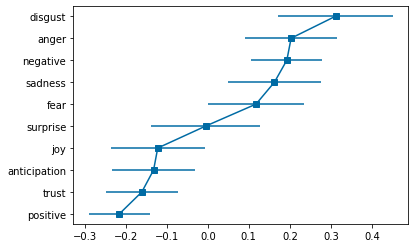

In [70]:
df_odd_ratio = df_odd_ratio.sort_values(by='log_or', ascending=True) 
plt.errorbar(df_odd_ratio['log_or'], df_odd_ratio['sentiment'], marker='s', xerr=((df_odd_ratio.log_or - df_odd_ratio.conf_low), (df_odd_ratio.conf_high - df_odd_ratio.log_or)))
plt.show()